# EDA - студенты и математика.

Цель проекта —  отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска с помощью модели, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы.

Задачи:
- Провести разведывательный анализ данных.
- Выбрать признаки для построения будущей модели.
- Составить отчёт по результатам анализа.


Импортируем нужные для чтения и первичного анализа библиотеки и прочитаем файл.

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import numpy as np

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок
students = pd.read_csv('stud_math.csv')

params = {'figure.constrained_layout.use': False,
          'axes.facecolor': 'gainsboro',
          'axes.grid': True,
          'grid.linestyle': '--',
          'axes.labelsize': 16,
          'axes.titlesize': 18,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16}
plt.rcParams.update(params)
%matplotlib inline

## Содержание<a name="1"></a>

1. [Предобработка](#2)
1. [Первичный отсмотр данных](#3)
2. [Первичный анализ данных в стобцах](#4)
3. [Корреляционный анализ](#5)
4. [Анализ номинативных переменных](#6)
5. [Итоговые выводы](#7)

***

## 1. Предобработка<a name="2"></a>

Напишем здесь все функции, которые будут использоваться в дальнейшем анализе:

In [35]:
def get_countplot(tpl):
    '''Функция для строковых столбцов.

    Позволяет, как выводить единичный график,
    так и несколько графиков в отдельных полях.
    Также выводит процент пропусков для каждого 
    графика и количество значений.
    '''
    fig = plt.figure(figsize=(20 if len(tpl) > 1 else 12,
                              7*((len(tpl)//3)+1)), dpi=80)
    gs = fig.add_gridspec((len(tpl)//3)+1,
                           len(tpl) if len(tpl) <= 3 else 3)
    for i in range(len(tpl)):
        ax = fig.add_subplot(gs[i//3, i % 3])
        col = students[tpl[i]].value_counts(ascending=True) # Процент пропусков
        pct_missing = round(np.mean(students[tpl[i]].isnull())*100, 2)
        max_value = col.max()
        sns.countplot(x=tpl[i],
                      data=students,
                      order=col.index,
                      palette='Blues',
                      edgecolor='k',
                      linewidth=2)
        ax.set_title(f'Распределения признака {tpl[i]}')
        ax.set_ylim(0, max_value+max_value*0.2)
        ax.set_ylabel('Количество')
        for i, value in enumerate(col.values): # Количество значений
            ax.text(i, value+0.5, value,
                    horizontalalignment='center',
                    fontsize=14,
                    bbox={'facecolor': 'w'})
        ax.text(0, max_value+max_value*0.1,
                f'Процент пропусков: {pct_missing}%',
                fontsize=16, bbox={'facecolor': 'w'})

In [36]:
def get_histogram(tpl):
    '''Функция для числовых столбцов.
    
    Позволяет, как выводить единичный график,
    так и несколько графиков в отдельных полях.
    Также выводит процент пропусков для каждого 
    графика, медиану и среднее.
    '''
    fig = plt.figure(figsize=(20 if len(tpl) > 1 else 12,
                              7*((len(tpl)//2)+1)), dpi=80)
    gs = fig.add_gridspec((len(tpl)//2)+1,
                           len(tpl) if len(tpl) <= 2 else 2)
    for i in range(len(tpl)):
        ax = fig.add_subplot(gs[i//2, i % 2])
        col = students[tpl[i]]
        counts, bins = np.histogram(col.dropna())
        pct_missing = round(np.mean(col.isnull())*100, 2) # Процент пропусков
        ax.hist(bins[:-1], bins,
                weights=counts,
                color='steelblue',
                edgecolor='k',
                linewidth=2)
        ax.set_title(f'Распределения признака {tpl[i]}')
        ax.set_ylim(0, max(counts)+max(counts)*0.15)
        ax.axvline(col.median(), color='w',
                   linestyle='--', linewidth=3)
        ax.axvline(col.mean(), color='k',
                   linestyle='--', linewidth=3)
        ax.text(col.mean()*1.01, max(counts)*0.9, # Среднее
                f'Mean: {round(col.mean(), 2)}', 
                color='w',fontsize=14, 
                bbox={'facecolor': 'k'})
        ax.text(col.median()*1.01, max(counts)*0.8, # Медиана
                f'Median: {round(col.median(), 2)}',
                fontsize=14, bbox={'facecolor': 'w', 
                                   'edgecolor': 'w'})
        ax.text(col.min(), max(counts)+max(counts)*0.06,
                f'Процент пропусков: {pct_missing}%',
                fontsize=16, bbox={'facecolor': 'w'})

In [37]:
def first_look(*args):
    '''Функция для вывода графиков.
    
    Может прнимать как отдельные значения,
    так и спискок значений.
    '''
    if type(args[0]) == list:
        args = args[0]

    if students[args[0]].dtype == 'O':
        return get_countplot(args)
    else:
        return get_histogram(args)

In [38]:
def iqr_filter(col):
    '''Функция для вывода выбросов.
    
    Фильтрует по формуле интерквартильного 
    расстояния и формирует таблицу в виде
    выброс-оценка.
    '''
    df = students
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    IQR = perc75 - perc25
    l_iqr = perc25 - 1.5*IQR
    r_iqr = perc75 + 1.5*IQR
    print('25-й перцентиль:', perc25)
    print('75-й перцентиль:', perc75)
    print('IQR:', IQR)

    return df.loc[~df[col].between(l_iqr, r_iqr)][[col, 'score']].sort_values([col]).dropna()

In [39]:
def fill_missing(*args):
    '''Функция для заполнения пропусков.
    
    Может прнимать как отдельные значения,
    так и список значений.
    Группирует принимаемый столбец с 
    оценками по количеству значений. 
    Затем заменяет пропуски на максимальное 
    значение из сгруппированного датафрейма 
    по оценке.
    Также, отдельно для столбца "fjob", 
    заполняет пропуски в строках с самыми 
    редкими оценками самым популярным значением"
    '''
    if type(args[0]) == list:
        args = args[0]

    df = students
    for i in range(len(args)):
        score_counts = df.groupby(['score'])[args[i]]\
            .value_counts().unstack().T
        if args[i] == 'fjob':
            df[args[i]] = df[[args[i], 'score']]\
                .apply(lambda x: df[args[i]].mode()[0] if
                       x[1] == 100 or x[1] == 20 else x[0], axis=1)
        df[args[i]] = df[[args[i], 'score']]\
            .apply(lambda x: score_counts[x[1]].idxmax() if
                   pd.isna(x[0]) else x[0], axis=1)
        print(f'Пропуски в столбце {args[i]} заполнены')

In [40]:
def get_jointplot(x, y):
    '''Функция для вывода графика регрессии и корреляции'''
    corr = round(students[[x, y]].corr().values[0][1], 2)
    sns.jointplot(x=x, y=y, 
                  data=students, 
                  kind='reg', 
                  color='xkcd:darkish blue')
    print('----------------')
    print(f'Корреляция: {corr}')
    print('----------------')

In [41]:
def add_n_obs(df, group_col, y):
    '''Функция для вывода количества значений на боксплотах.'''
    medians_dict = {grp[0]: grp[1][y].median()
                    for grp in df.groupby(group_col)}
    xticklabels = [x.get_text() for x in plt.gca().get_xticklabels()]
    counts = df.groupby(group_col)[y].size().values
    for (x, xticklabel), count in zip(enumerate(xticklabels), counts):
        plt.text(x, medians_dict[xticklabel]*1.04, 
                 str(count), horizontalalignment='center',
                 fontsize=14, bbox={'facecolor': 'w'})

In [42]:
def get_stat_dif(col):
    '''Функция для теста Стьюдента.
    
    Возвращает текст, если найдены
    статистически значимые различия.
    '''
    df = students
    cols = df[col].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df[col] == comb[0], 'score'],
                     df.loc[df[col] == comb[1], 'score']).pvalue \
                     <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            return 'ttest: значимые различия'
            break

In [43]:
def get_anova(col):
    '''Функция для однофакторного дисперсионного аналиа.
    
    Возвращает текст, если найдены статистически значимые различия.
    '''
    df = students
    values = df[col].value_counts().index
    values_array = []
    for value in values:
        values_array.append(df.loc[df[col] == value, 'score'])
    if f_oneway(*values_array).pvalue <= 0.05:
        return 'ANOVA: значимые различия'

In [44]:
def get_boxplot(*args):
    '''Функция вывода боксплотов.
    
    Может прнимать как отдельные значения,
    так и список значений.
    Позволяет, как выводить единичный график,
    так и несколько графиков в отдельных полях.
    Также выводит количество значений и информацию
    о прохождении тестов.
    '''
    if type(args[0]) == list:
        args = args[0]

    fig = plt.figure(figsize=(20 if len(args) > 1 else 12,
                              7*((len(args)//3)+1)), dpi=80)
    gs = fig.add_gridspec((len(args)//3)+1,
                           len(args) if len(args) <= 3 else 3)
    for i in range(len(args)):
        ax = fig.add_subplot(gs[i//3, i % 3])

        sns.boxplot(x=args[i], y='score',
                    data=students, palette='Blues')
        ax.set_title('Формы распределения для ' + args[i])
        ax.set_ylim(0, 120)
        add_n_obs(students, args[i], 'score') # Количество значений
        ax.text(0, 110, get_stat_dif(args[i]), # ttest
                fontsize=16, bbox={'facecolor': 'w'})
        ax.text(0, 10, get_anova(args[i]), # ANOVA
                fontsize=16, bbox={'facecolor': 'w'})

[К содержанию](#1)

***

## 2. Первичный отсмотр данных<a name="3"></a>

In [45]:
display(students.tail(5))
students.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,NaN,1.0,2.0,2.0,no,yes,yes,no,yes,-6.0,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0
391,MS,M,17,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,no,no,no,no,no,-3.0,yes,yes,no,2.0,4.0,5.0,2.0,3.0,80.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,NaN,1.0,1.0,3.0,NaN,no,no,no,no,-3.0,NaN,no,no,5.0,5.0,3.0,3.0,3.0,35.0
393,MS,M,18,R,LE3,T,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,no,no,no,NaN,no,-3.0,yes,yes,no,4.0,4.0,1.0,5.0,0.0,50.0
394,MS,M,19,U,LE3,T,1.0,1.0,other,at_home,NaN,father,1.0,1.0,0.0,NaN,no,no,no,yes,-3.0,yes,yes,no,3.0,2.0,3.0,5.0,5.0,45.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

В датасете 395 строк, 30 стобцов, из них 13 - числовые, 17 - строковые. Во всех столбцах, кроме __school__, __sex__ и __age__, присутствуют пустые значения, но их количество не критичное. В дальнейшем решим, как заполнить пропуски. Так как по заданию __score__ - предсказываемая величина, сразу удалим строки с пропусками в это столбце:

In [46]:
students = students[students['score'].notnull()]

[К содержанию](#1)

***

## 3. Первичный анализ данных в стобцах<a name="4"></a>

Для начала переведем все названия столбцов в нижний регистр для удобства:

In [47]:
students.columns = [col.lower() for col in students.columns]

Посмотрим описательные статистики:

In [48]:
students.describe()

,age,medu,fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
count,389.000000,386.000000,365.000000,361.000000,382.000000,367.000000,382.000000,362.000000,380.000000,382.000000,374.000000,378.000000,389.000000
mean,16.673522,2.766839,2.627397,1.434903,2.036649,0.326975,-6.109948,3.930939,3.223684,3.094241,3.529412,7.320106,52.262211
std,1.265662,1.094277,2.241790,0.692660,0.847239,0.729479,2.541716,0.931554,0.993364,1.116104,1.402006,23.615525,22.919022
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-12.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,-6.000000,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,17.000000,3.000000,3.000000,1.000000,2.000000,0.000000,-6.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,-3.000000,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,40.000000,4.000000,4.000000,3.000000,-3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


In [49]:
students.describe(include='O')

,school,sex,address,famsize,pstatus,mjob,fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
count,389,389,374,362,344,370,353,372,358,380,351,350,375,374,369,355,358
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2
top,GP,F,U,GT3,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no
freq,344,204,291,255,308,127,194,135,248,331,216,197,192,297,350,300,235


В столбцах __absences__, __fedu__ и __famrel__ наблюдаются странные значения. Остальные столбцы выглядят нормально. В строковых столбцах не больше пяти уникальных значений.

Посмотрим на предсказываемую переменную __score__:

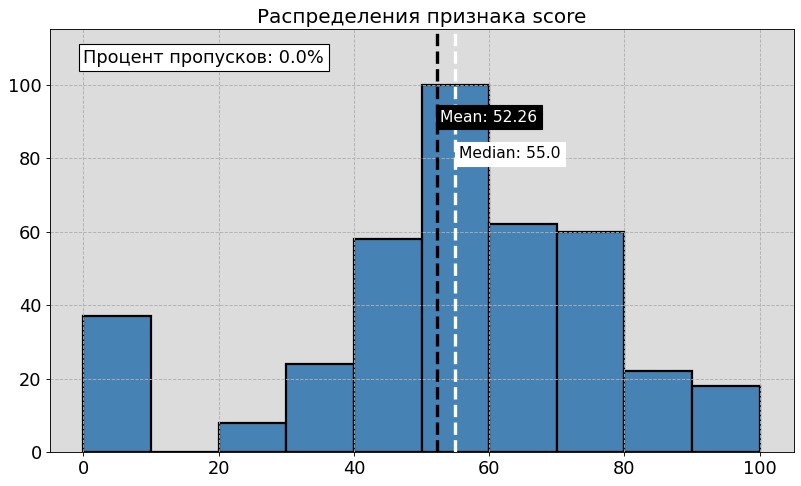

In [50]:
first_look('score')

Бросается в глаза большое количество оценок близких к нулю в столбце __score__. Посмотрим внимательнее:

In [51]:
students['score'].value_counts().sort_index()

0.0      37
20.0      1
25.0      7
30.0     15
35.0      9
40.0     31
45.0     27
50.0     54
55.0     46
60.0     31
65.0     31
70.0     27
75.0     33
80.0     16
85.0      6
90.0     12
95.0      5
100.0     1
Name: score, dtype: int64

Такое количество нулей выглядит достаточно странно, учитывая, что без них оценки распределены примерно нормально, а следующая минимальная оценка равна 20-и, и такая оценка одна. Можно предположить, что 20 и есть минимальная оценка за экзамен, а 0 ставился за неявку. В любом случае, в рамках нашей задачи, эти данные будут мешать дальнейшему построению модели, поэтому удалим их:

In [52]:
students = students[students['score'] != 0]

Теперь посмотрим на остальные столбцы:

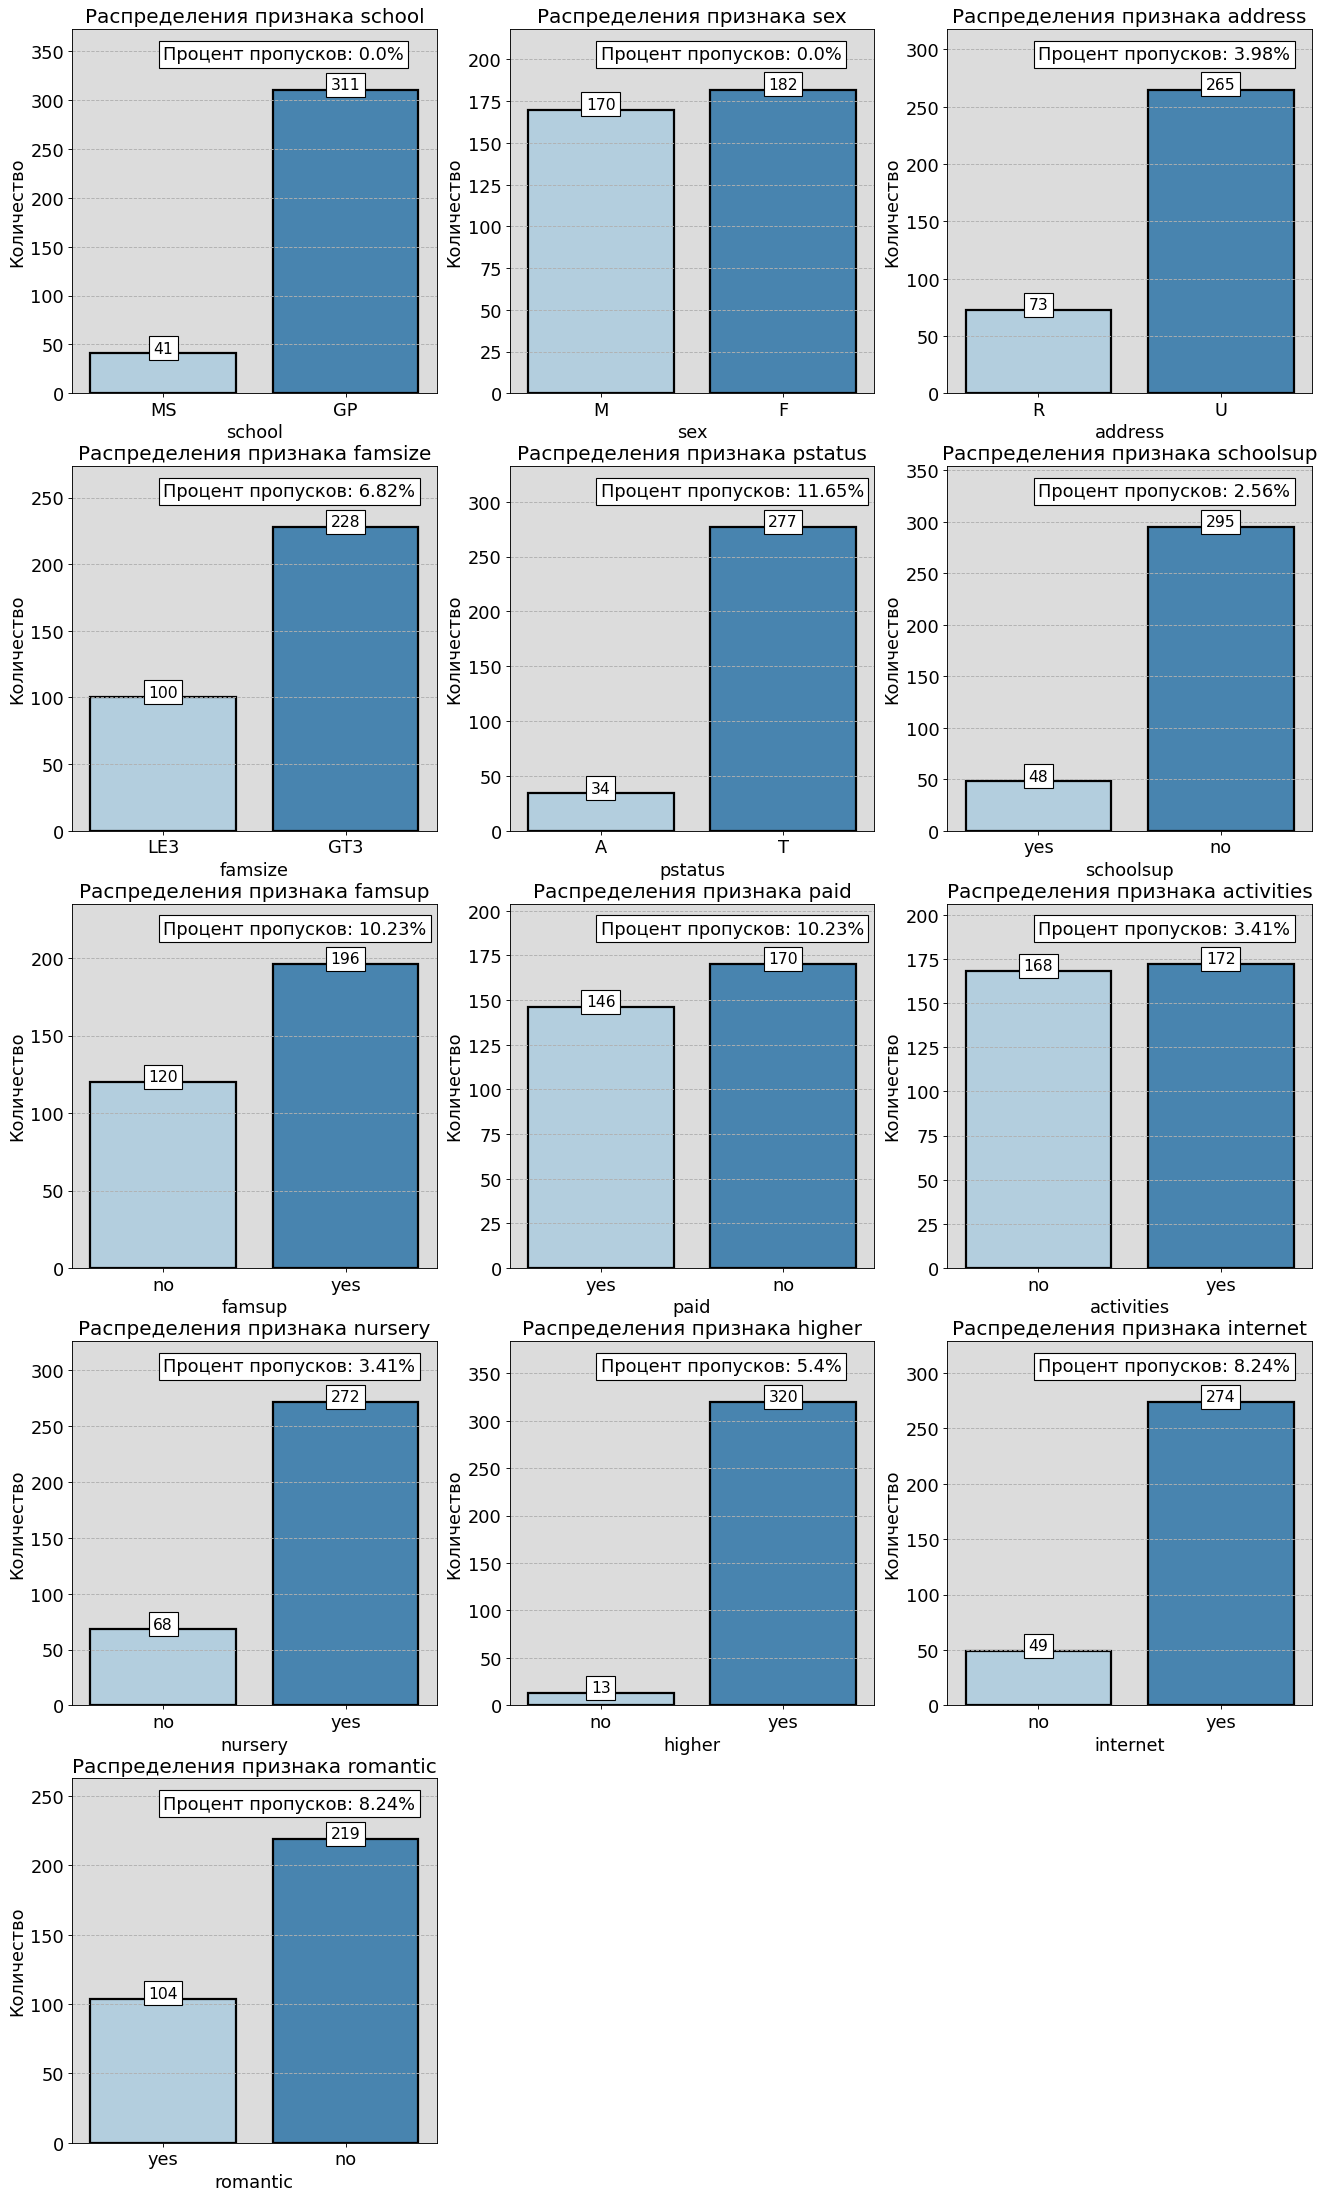

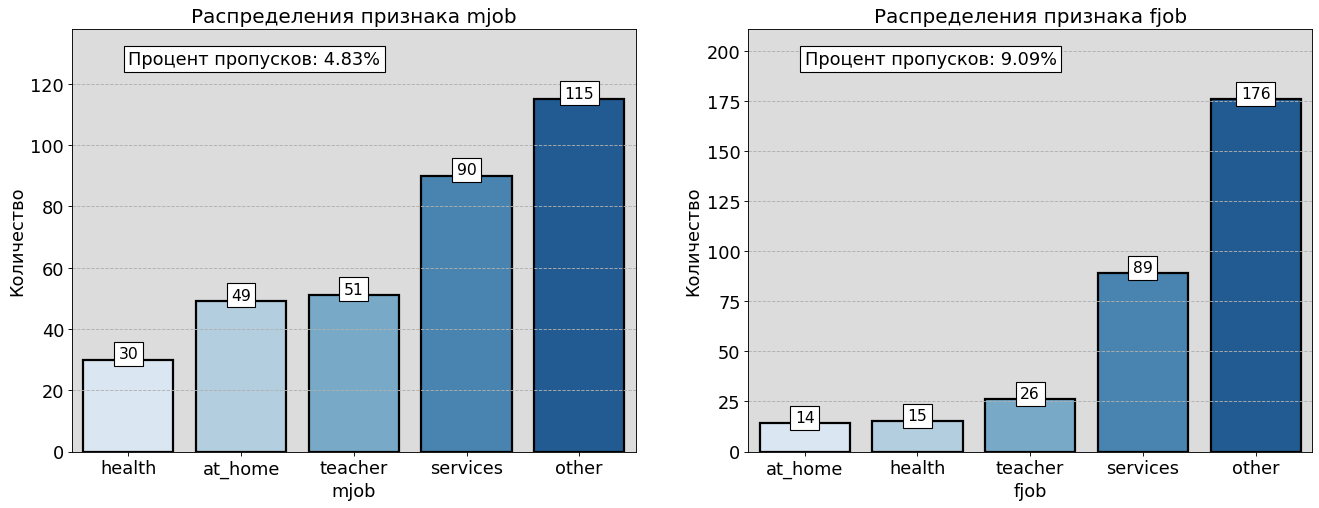

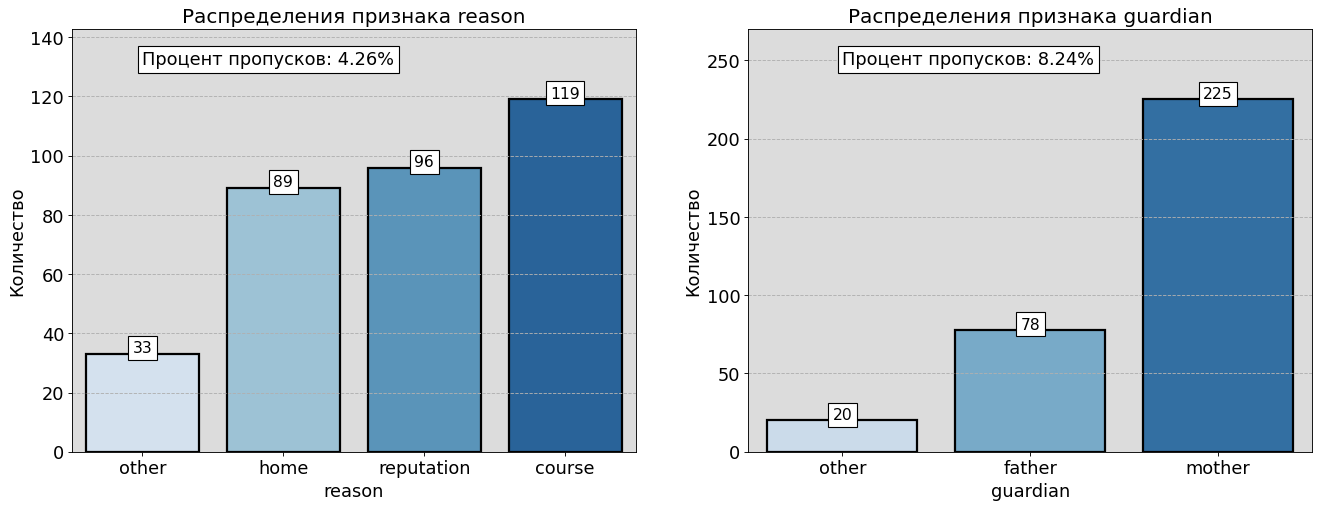

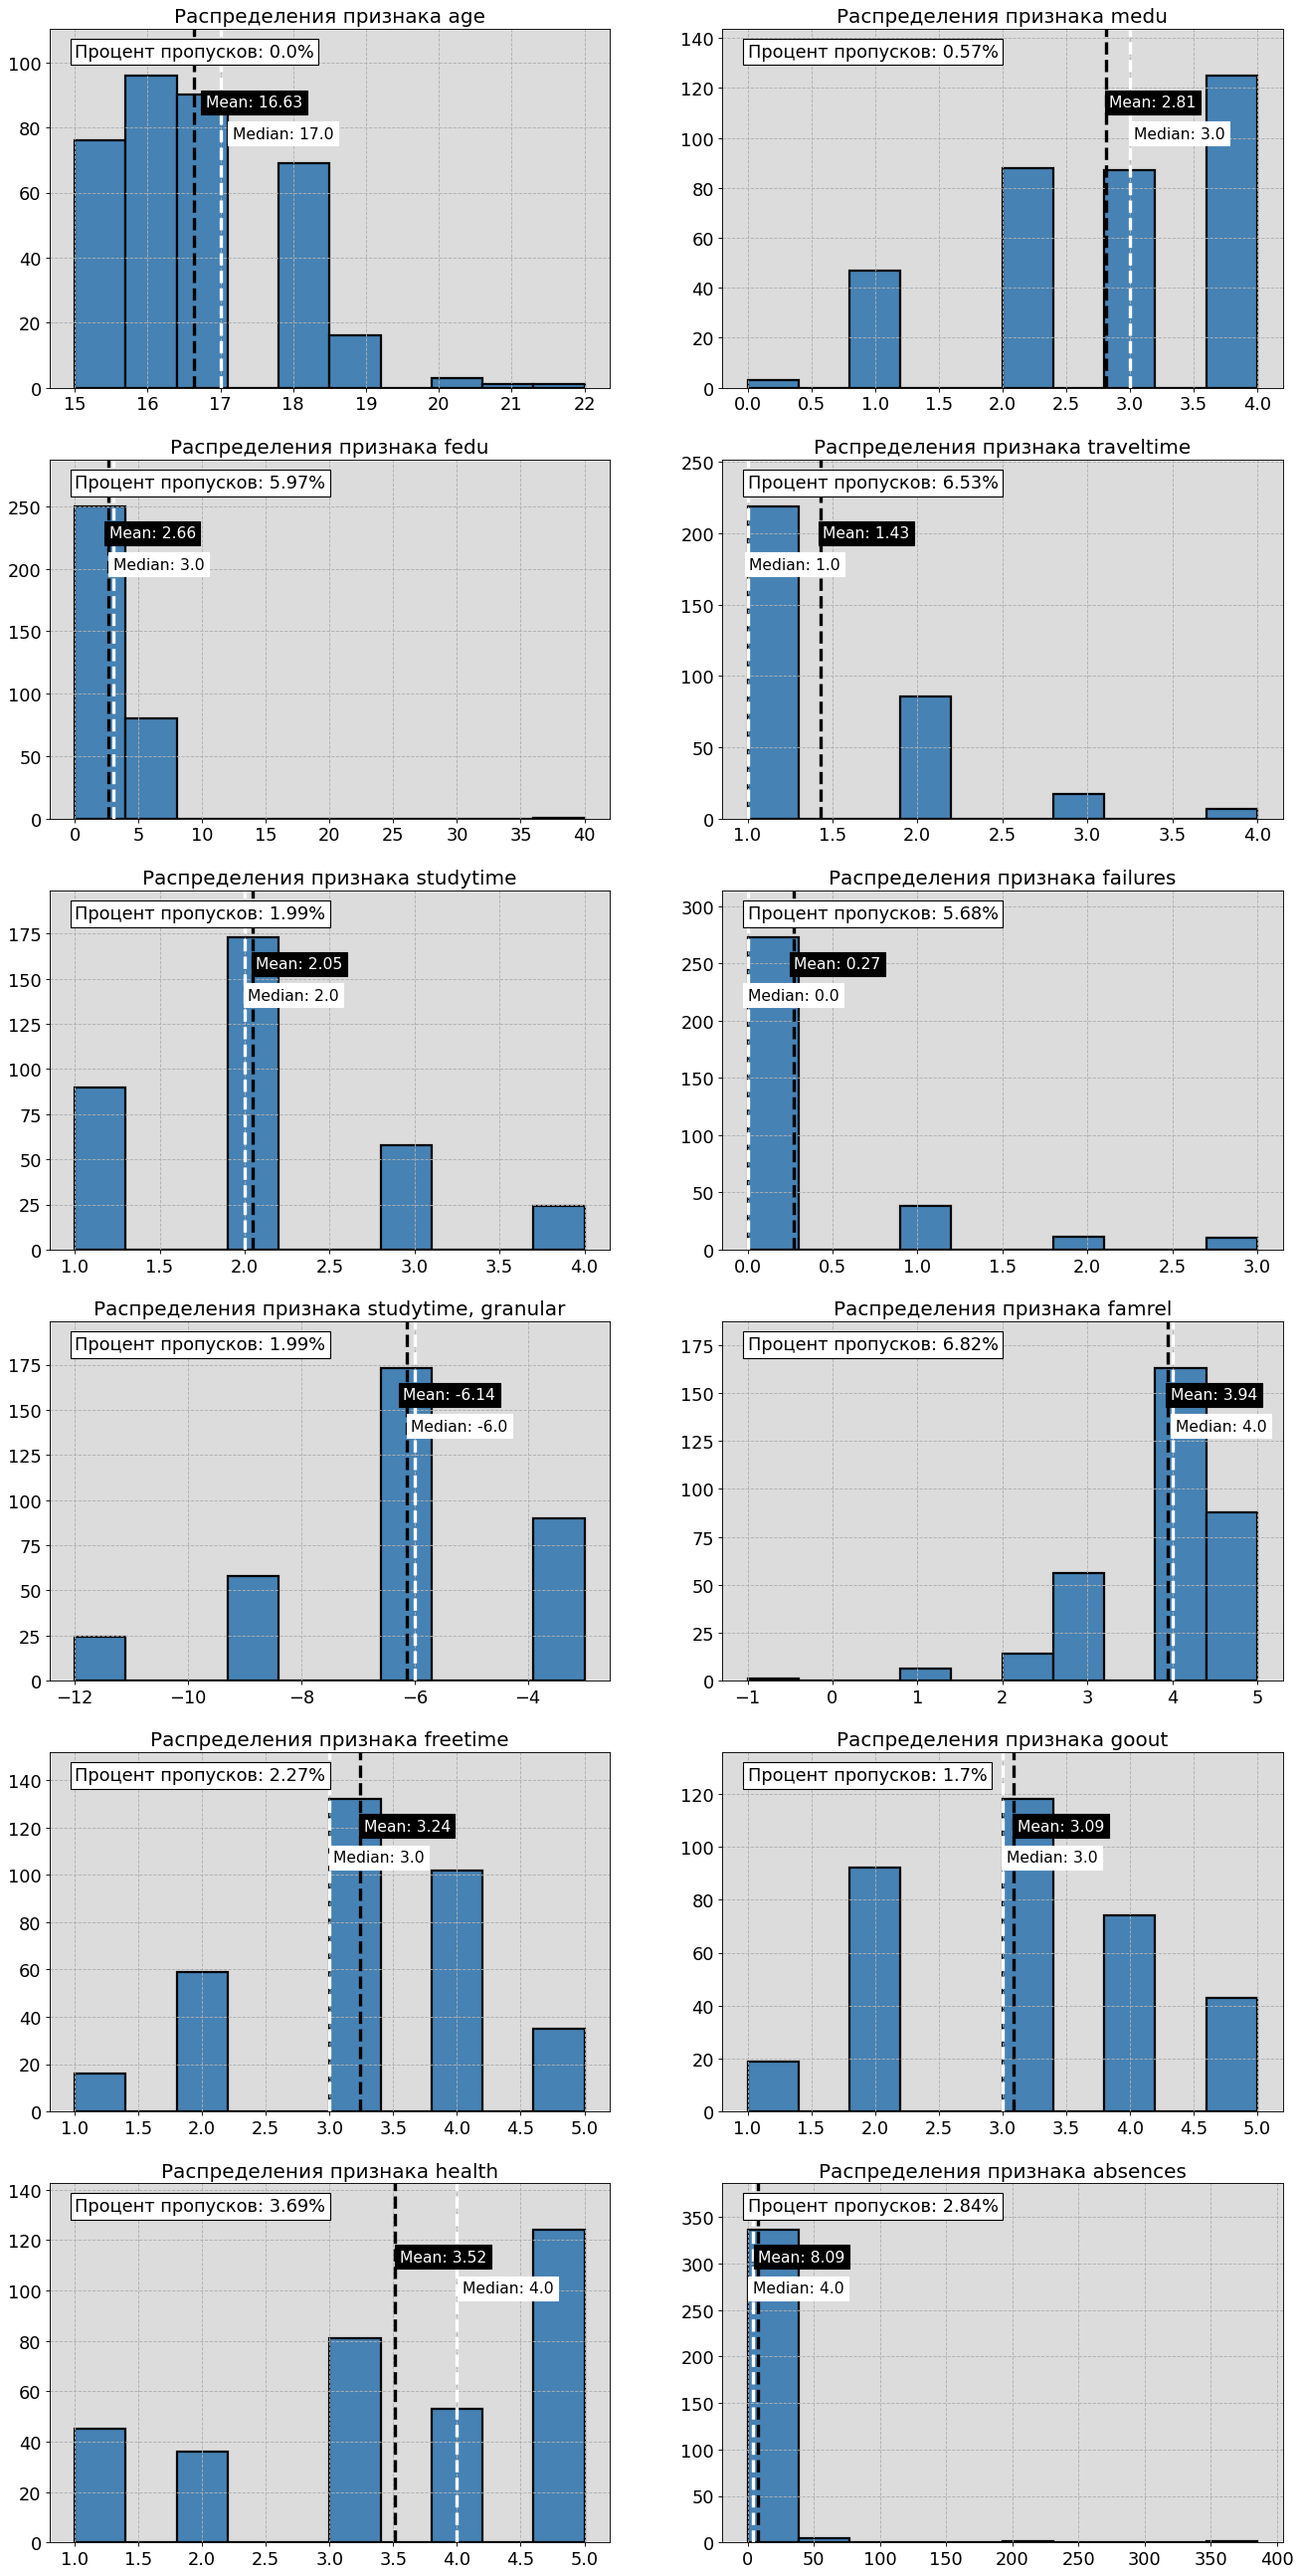

In [53]:
first_look([col for col in students.columns if
            students[col].nunique() == 2 and
            students[col].dtype == 'O'])
first_look([col for col in students.columns if
            students[col].nunique() == 5 and
            students[col].dtype == 'O'])
first_look([col for col in students.columns if
            students[col].nunique() == 3 or
            students[col].nunique() == 4 and
            students[col].dtype == 'O'])
first_look([col for col in students.columns if
            col != 'score' and students[col].dtype != 'O'])

Доля пропусков по столбцам небольшая, от __0.6%__ до __11.7%__. Интересен значительно больший процент пропусков в столбцах с информацией по отцу, чем в материнских столбцах. Можно предположить, что семей, где мать растит ребенка в одиночку, больше, чем семей, где эту функцию выполняет отец. Это косвенно подтверждают данные из столбца __guardian__.  

В столбцах __fedu__ и __famrel__ наблюдаются выбросы, судя по вводным данным к датасету. Также в столбце __absences__ пики в районе двуxсот и трехсотпятидесяти выглядят аномальными, особенно если учитывать, что от нулевых оценок мы избавились. В остальном данные достаточно чистые. Странными выглядят столбцы __studytime__ и __studytime, granular__, которые зеркальны по отношению друг к другу и с одинковым пронцетом пропусков. С них и начнем:

----------------
Корреляция: -1.0
----------------


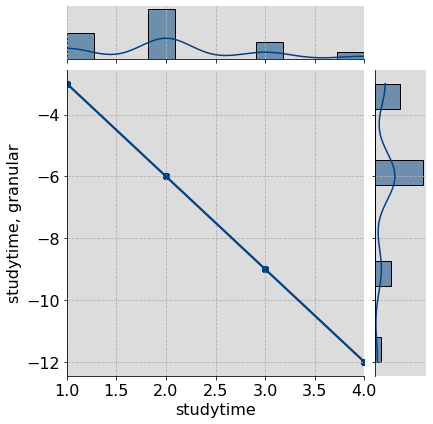

In [54]:
get_jointplot('studytime', 'studytime, granular')

Как и ожидалось, эти столбцы полностью скоррелированы и, по сути, дублируют друг друга. Удалим __studytime, granular__, потому что о нем нет информации в вводных данных:

In [55]:
students.drop('studytime, granular', axis=1, inplace=True)

Теперь посмотрим на столбцы __fedu__ и __famrel__:

In [56]:
students['fedu'].value_counts().sort_index()

0.0      2
1.0     65
2.0     94
3.0     89
4.0     80
40.0     1
Name: fedu, dtype: int64

In [57]:
students['famrel'].value_counts().sort_index()

-1.0      1
 1.0      6
 2.0     14
 3.0     56
 4.0    163
 5.0     88
Name: famrel, dtype: int64

По вводным данным распредление значений для __fedu__ от __0__ до __4__, а для __famrel__ от __1__ до __5__. Значения __40__ и __-1__ похожи на ошибки при вводе данных. Предположим, что __40__ в столбце __fedu__ - это __4__, а __-1__ в столбце __famrel__ - это __1__. Исправим:

In [58]:
students.loc[students['fedu'] == 40, 'fedu'] = 4
students.loc[students['famrel'] == -1, 'famrel'] = 1

Для того, чтобы разобраться со столбцом __absences__, воспользуемся __формулой интерквартильного расстояния__. И посмотрим, как выбросы по формуле соотносятся со столбцом __score__:

In [59]:
iqr_filter('absences')

25-й перцентиль: 2.0
75-й перцентиль: 8.0
IQR: 6.0


,absences,score
89,18.0,35.0
123,18.0,65.0
309,18.0,50.0
203,18.0,30.0
234,18.0,30.0
281,19.0,50.0
237,20.0,60.0
311,20.0,65.0
118,20.0,40.0
304,20.0,65.0


Здравый смысл подказывает, что большинство выбросов по формуле таковыми не являются, если соотносить их с оценками. Очевидные выбросы - это два максимальных значения, которые превышают количество учебных дней в году. Так как датасет небольшой, не будем их удалять, а предположим, что пропуски занятий действительно влияют на оценку, и подберем самые популярные  значения по отношению к полученным оценкам в строках с выбросами:

In [60]:
score_counts = students.groupby(['score'])['absences']\
    .value_counts().unstack().T
students['absences'] = students[['absences', 'score']]\
    .apply(lambda x: score_counts[x[1]].idxmax() if
           x[0] == 212 or x[0] == 385 else x[0], axis=1)

Подобным образом поступим и с пропусками в столбцах:

In [61]:
fill_missing([col for col in 
              students.columns if 
              students[col].name != 'score'])

Пропуски в столбце school заполнены
Пропуски в столбце sex заполнены
Пропуски в столбце age заполнены
Пропуски в столбце address заполнены
Пропуски в столбце famsize заполнены
Пропуски в столбце pstatus заполнены
Пропуски в столбце medu заполнены
Пропуски в столбце fedu заполнены
Пропуски в столбце mjob заполнены
Пропуски в столбце fjob заполнены
Пропуски в столбце reason заполнены
Пропуски в столбце guardian заполнены
Пропуски в столбце traveltime заполнены
Пропуски в столбце studytime заполнены
Пропуски в столбце failures заполнены
Пропуски в столбце schoolsup заполнены
Пропуски в столбце famsup заполнены
Пропуски в столбце paid заполнены
Пропуски в столбце activities заполнены
Пропуски в столбце nursery заполнены
Пропуски в столбце higher заполнены
Пропуски в столбце internet заполнены
Пропуски в столбце romantic заполнены
Пропуски в столбце famrel заполнены
Пропуски в столбце freetime заполнены
Пропуски в столбце goout заполнены
Пропуски в столбце health заполнены
Пропуски в столбц

[К содержанию](#1)

***

## 4. Корреляционный анализ<a name="5"></a>

Посмотрим, как чиловые столбцы коррелируют с полученной оценкой. Для наглядности используем матрицу корреляций:

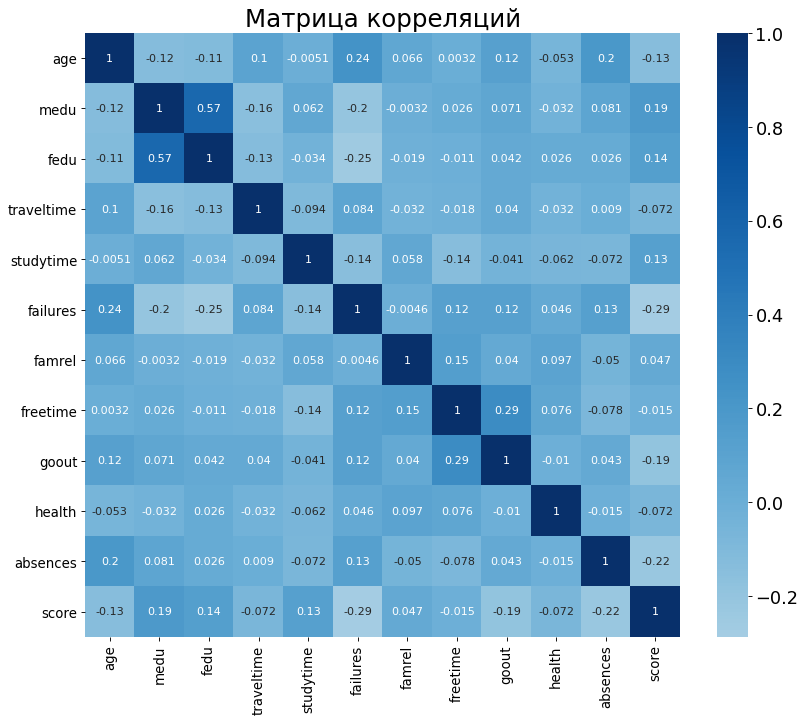

In [62]:
plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(students.corr(), xticklabels=students.corr().columns,
            yticklabels=students.corr().columns, 
            cmap='Blues', center=0, annot=True)
plt.title('Матрица корреляций', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Логично объясняется положительная корреляция с уровнем образования родителей и потраченным временем на учебу, а также отрицательная - количеством пропусков, неудачами и посиделками с друзьями. Интересна отрицательная корреляция возраста. Судя по матрице, это можно объяснить тем, что с возрастом приоритеты меняются в сторону большего общения с друзьями, а это в свою очередь влияет на количество пропусков и неудач.  

Также высокая положительная корреляция уровня образования родителей может говорить о том, что чаще создают семью пары с равным уровнем образования.  

Выберем для построения модели наиболее коррелирующие (значения от __0.1__ и от __-0.1__) с оценками. Это столбцы __age__, __medu__, __fedu__, __studytime__, __failures__, __goout__, __absences__. Удалим остальные чиловые столбцы:

In [63]:
students.drop(['traveltime', 'famrel', 'freetime', 'health'], axis = 1, inplace=True)

Интересно, что здоровье, время на дорогу в школу, отношения в семье и, особенно, свободное время почти не оказывают влияние на получаемую оценку.

[К содержанию](#1)

***

## 5. Анализ номинативных переменных<a name="6"></a>

Посмотрим на распределения номинативных переменных по отношению к полученной оценке, а также проверим, есть ли статистическая разница в распределении оценок, с помощью теста Стьюдента и однофакторного дисперсионного аналиа:

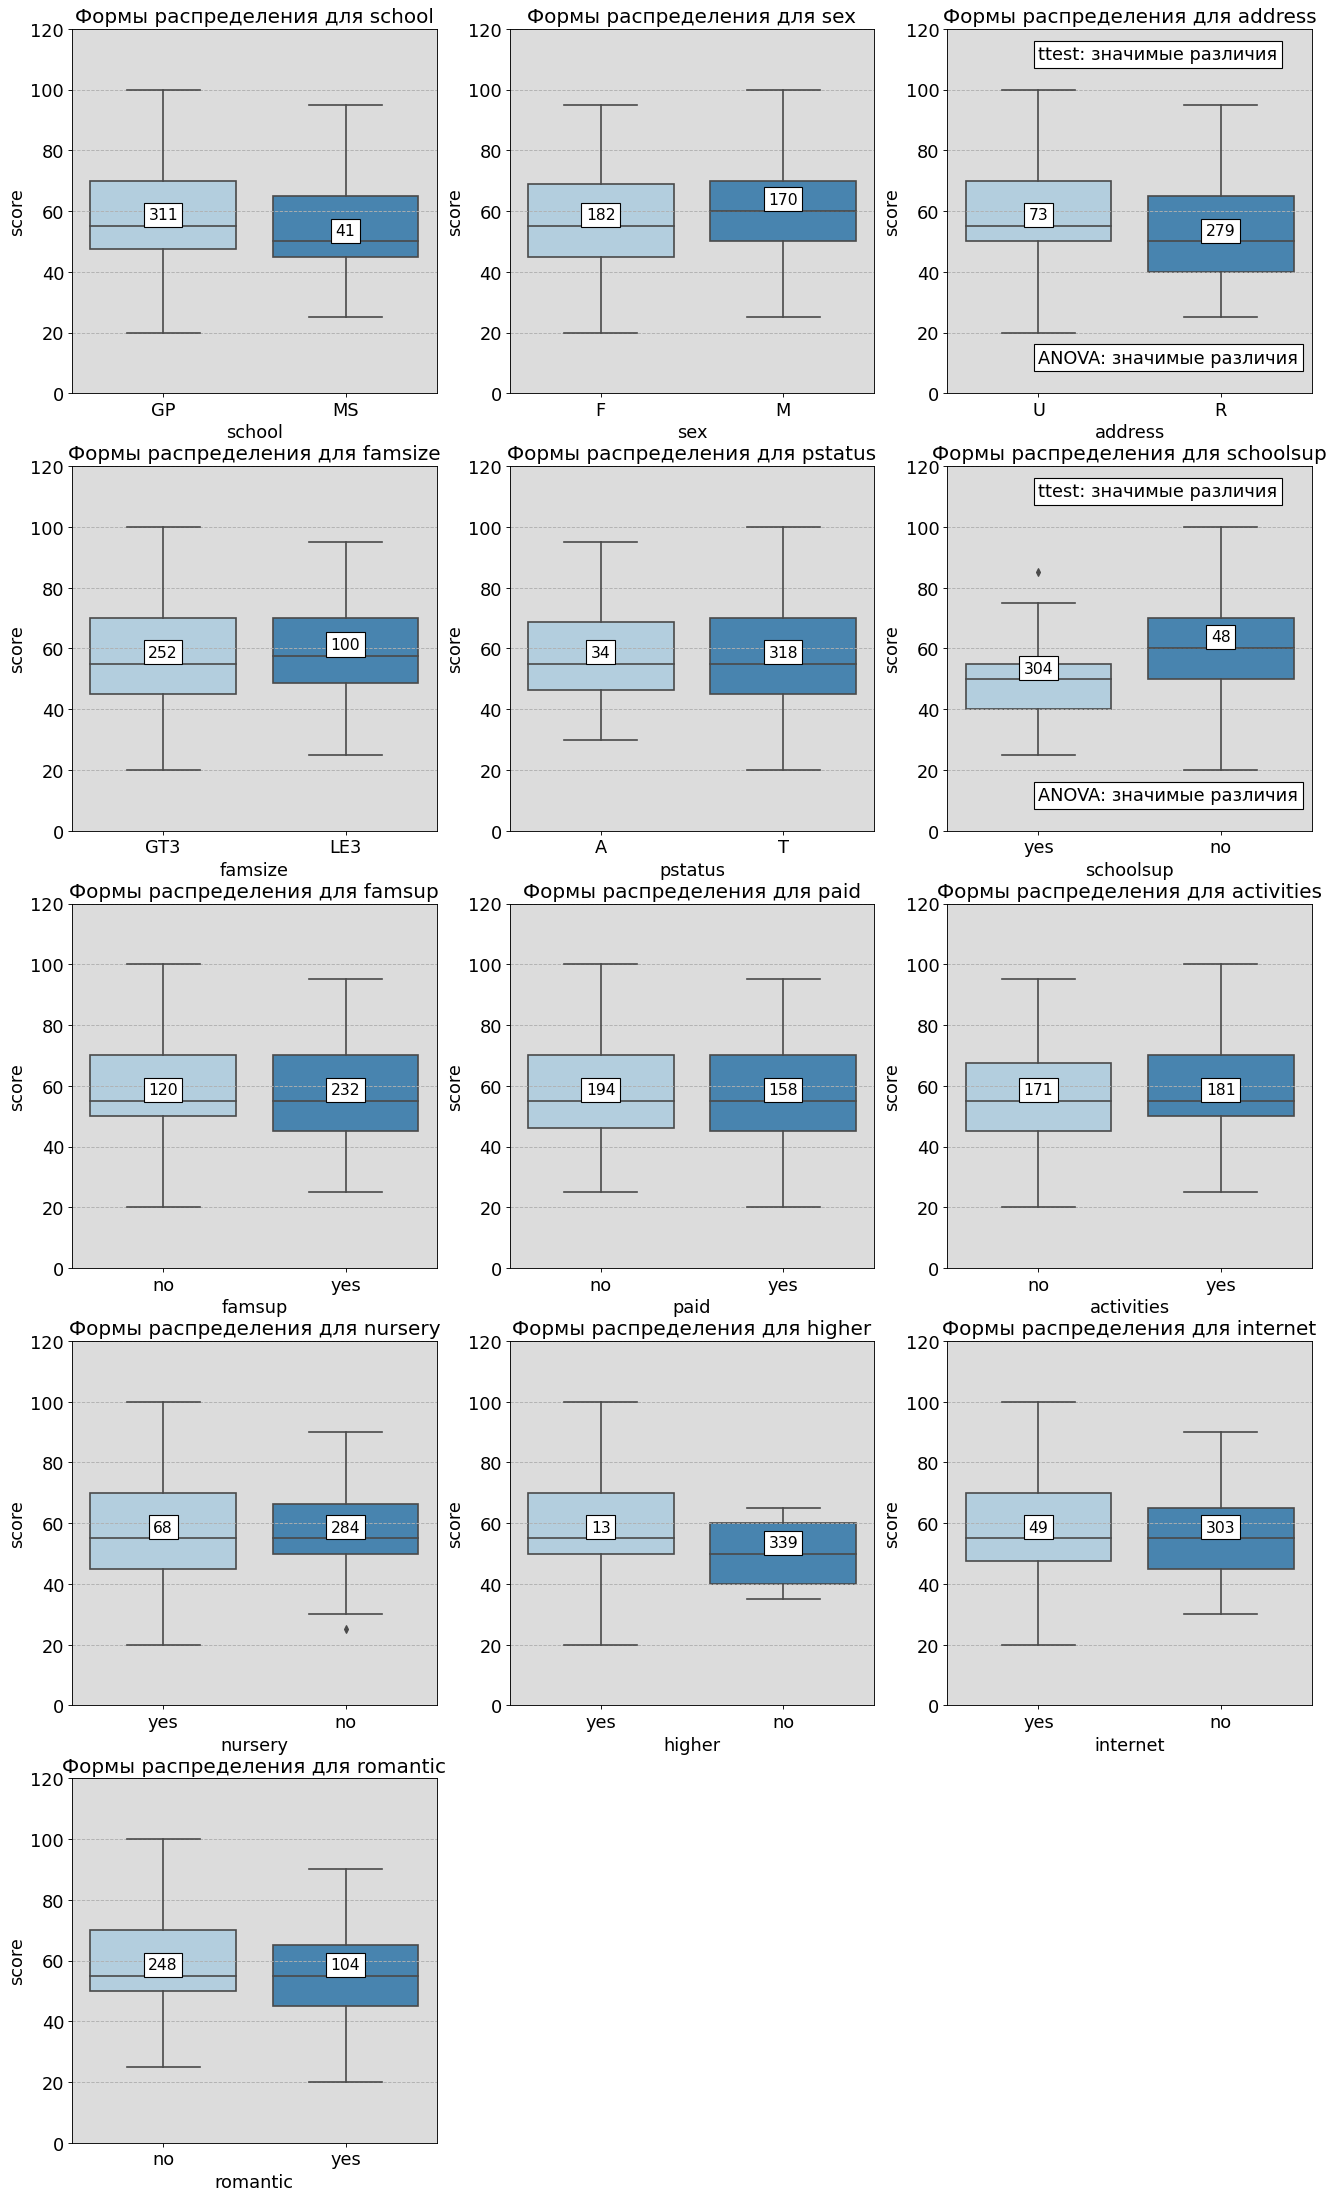

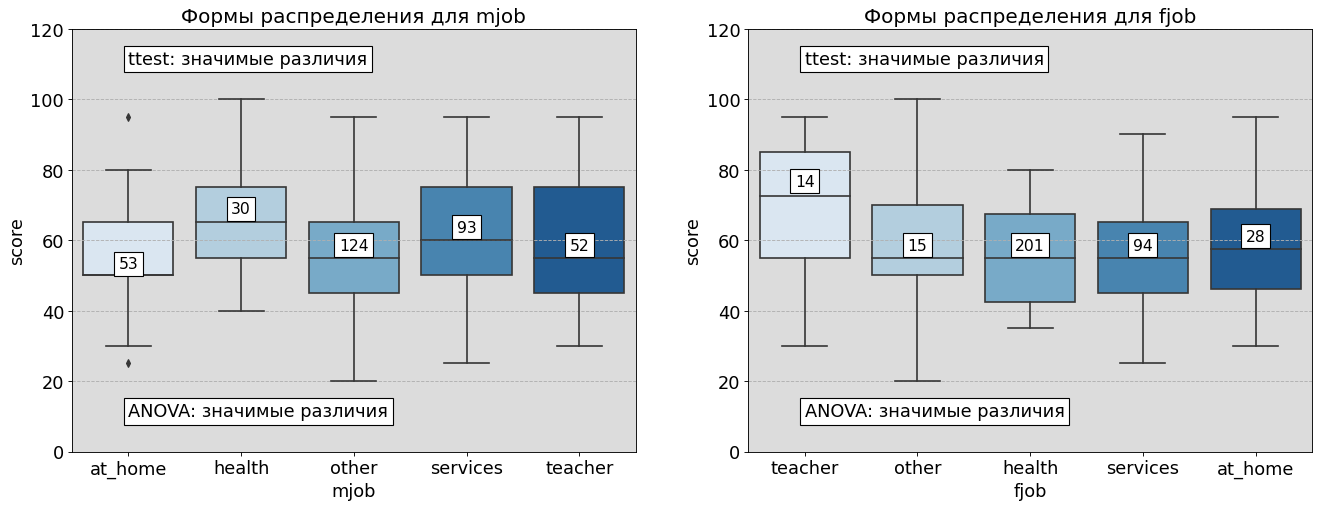

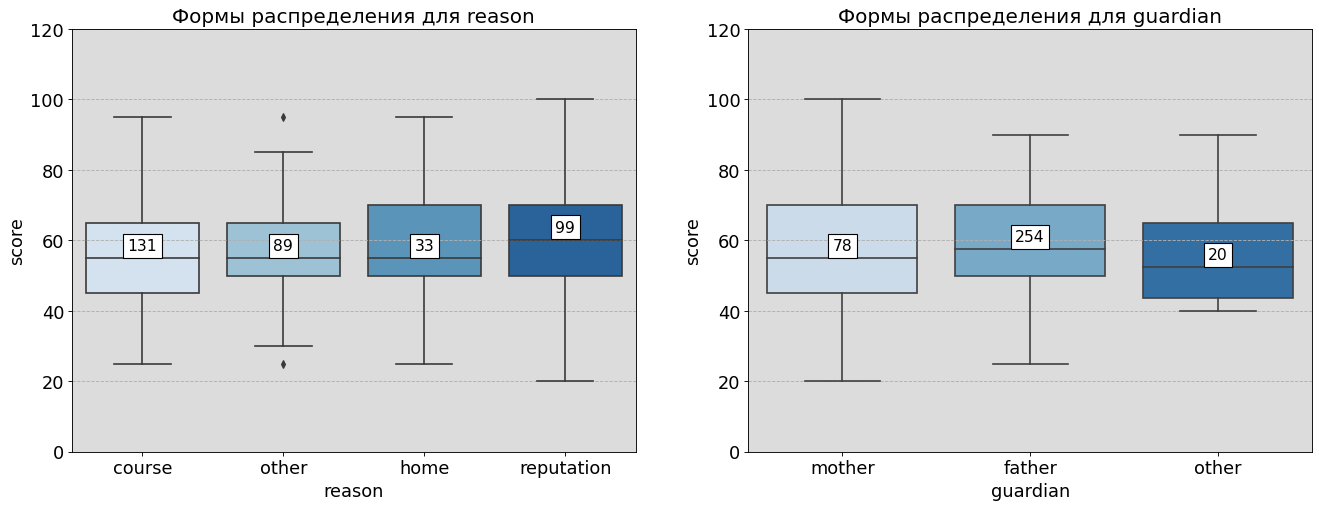

In [64]:
get_boxplot([col for col in students.columns if
             students[col].nunique() == 2 and
             students[col].dtype == 'O'])
get_boxplot([col for col in students.columns if 
             students[col].nunique() == 5 and
             students[col].dtype == 'O'])
get_boxplot([col for col in students.columns if 
             students[col].nunique() == 3 or 
             students[col].nunique() == 4 and 
             students[col].dtype == 'O'])

Серьёзно отличаются четыре параметра: address, schoolsup, mjob и fjob. Удалим остальные номинативныe переменныe из датасета: 

In [65]:
drop_columns = [col for col in students.columns if
                students[col].dtype == 'O' and
                col != 'address' and
                col != 'schoolsup' and
                col != 'mjob' and
                col != 'fjob']
students.drop(drop_columns, axis=1, inplace=True)

Интересно, что есть влияние на полученную оценку доп. образования, но нет влияния семейного образования.

Посмтрим, как изменился датасет после EDA:

In [66]:
students_for_model = students
students_for_model.head()

,age,address,medu,fedu,mjob,fjob,studytime,failures,schoolsup,goout,absences,score
0,18.0,U,4.0,4.0,at_home,teacher,2.0,0.0,yes,4.0,6.0,30.0
1,17.0,U,1.0,1.0,at_home,other,2.0,0.0,no,3.0,4.0,30.0
2,15.0,U,1.0,1.0,at_home,other,2.0,3.0,yes,2.0,10.0,50.0
3,15.0,U,4.0,2.0,health,other,3.0,0.0,no,2.0,2.0,75.0
4,16.0,U,3.0,3.0,other,other,2.0,0.0,no,2.0,4.0,50.0


[К содержанию](#1)

***

## 6. Итоговые выводы<a name="7"></a>

В результате EDA для анализа влияния условий жизни учащихся их успеваемость по математике были получены следующие выводы:

* Во всех столбцах, кроме __school__, __sex__ и __age__, присутствуют пустые значения, от __0.6%__ до __11.7%__ в зависимости от столбца.
* Большое количество нулей в столбце __score__ может говорить о том, что нули ставились за пропуск экзамена.
* Выбросы найдены только в столбцах __fedu__, __famrel__ и __absences__. В остальном данные достаточно чистые.
* Значительно больший процент пропусков в столбцах с информацией по отцу, чем в материнских столбцах может говорить о том, что матерей-одиночек больше, чем отцов-одиночек.
* Отрицательная корреляция параметра __age__ и __score__ может говорить о том, что возрастом дети больше уделяют внимае внешкольным активностям, чем учебе.
* Высокая положительная корреляция уровня образования родителей может говорить о том, что чаще создают семью пары с равным уровнем образования.
* Для дальнейшего построения модели рекомендуется использовать параметры __age__, __address__, __medu__, __fedu__, __mjob__, __fjob__, __studytime__, __failures__, __goout__ и __absences__.

[К содержанию](#1)